In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
from keras.models import load_model
import itertools 
filterwarnings('ignore')
np.random.seed(101)
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Tue Sep  6 18:21:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |    410MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train_dir ="/content/drive/MyDrive/HE/train"
val_dir="/content/drive/MyDrive/HE/test"
test_dir="/content/drive/MyDrive/HE/test"
labels = ['0', '1', '2', '3']
label_np=np.array(labels)

In [5]:
import tensorflow as tf
import numpy as np
import os
import random

def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


seed = 101
set_seed(seed)

In [6]:
model1 = Xception(include_top=False,input_shape=(299, 299,3), weights='imagenet')
input_shape = (299, 299)

83697664/83683744 [==============================] - 1s 0us/step


In [10]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=2,
                                  vertical_flip=True,
                                  horizontal_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

datagen_val=ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,                                        
                                                    shuffle=True)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
generator_test=datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                 batch_size=batch_size,
                                                 shuffle=False)

Found 3896 images belonging to 4 classes.
Found 977 images belonging to 4 classes.
Found 977 images belonging to 4 classes.


In [11]:
headModel = model1.output
headModel = layers.GlobalAveragePooling2D()(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = layers.BatchNormalization()(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(512, activation="relu", dtype='float32')(headModel)
headModel = layers.BatchNormalization()(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(4, activation="softmax")(headModel)
model = Model(inputs=model1.input, outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [12]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['accuracy','Precision','Recall', 'AUC']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [13]:

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

earlystopping = EarlyStopping(monitor ="val_loss", 
                              mode ="min", patience = 3, 
                              restore_best_weights = True)
history = model.fit_generator(generator=generator_train,
                              epochs=80,
                              validation_data=generator_val,
                              validation_steps=steps_test,
                              callbacks =[earlystopping]
                              )


Epoch 1/80
244/244 [==============================] - 1342s 5s/step - loss: 2.0215 - accuracy: 0.2074 - precision: 0.1871 - recall: 0.1140 - auc: 0.4603 - val_loss: 1.5149 - val_accuracy: 0.2098 - val_precision: 0.2759 - val_recall: 0.0246 - val_auc: 0.4399
Epoch 2/80
244/244 [==============================] - 212s 870ms/step - loss: 1.8495 - accuracy: 0.2390 - precision: 0.2378 - recall: 0.1404 - auc: 0.5014 - val_loss: 1.4639 - val_accuracy: 0.2692 - val_precision: 0.2815 - val_recall: 0.0389 - val_auc: 0.5260
Epoch 3/80
244/244 [==============================] - 210s 860ms/step - loss: 1.7525 - accuracy: 0.2723 - precision: 0.2937 - recall: 0.1676 - auc: 0.5313 - val_loss: 1.4079 - val_accuracy: 0.3378 - val_precision: 0.3765 - val_recall: 0.0952 - val_auc: 0.5908
Epoch 4/80
244/244 [==============================] - 209s 857ms/step - loss: 1.6765 - accuracy: 0.2929 - precision: 0.3136 - recall: 0.1810 - auc: 0.5582 - val_loss: 1.3219 - val_accuracy: 0.3818 - val_precision: 0.4841 -

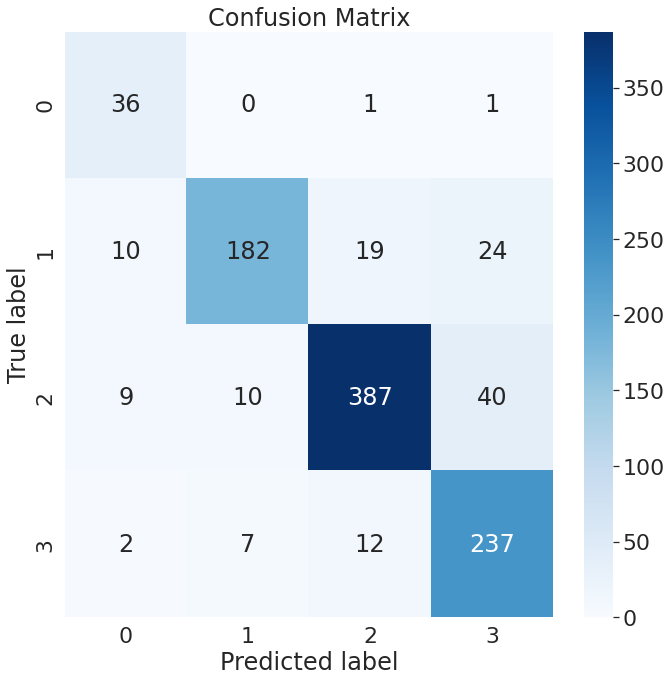

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(generator_test)
y_pred = np.argmax(Y_pred, axis=1)
array = confusion_matrix(generator_test.classes, y_pred)
df_cm = pd.DataFrame(array, index =['0', '1', '2', '3'],
                  columns = ['0', '1', '2', '3'])
plt.figure(figsize=(10,10))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('model1_confusion',dpi=200); 
plt.show()

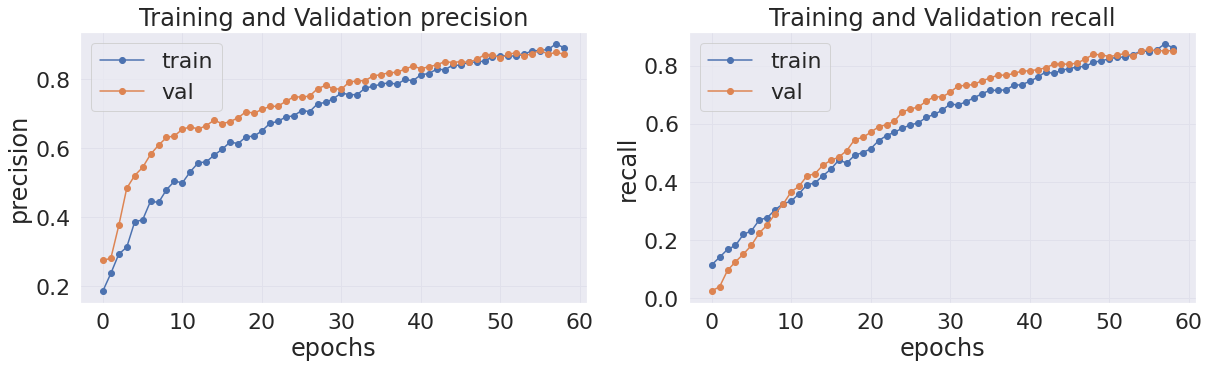

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met],'o-')
    ax[i].plot(history.history['val_' + met],'o-')
    ax[i].set_title('Training and Validation {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'])

fig.savefig('model1_precision_recall',dpi=1200); 

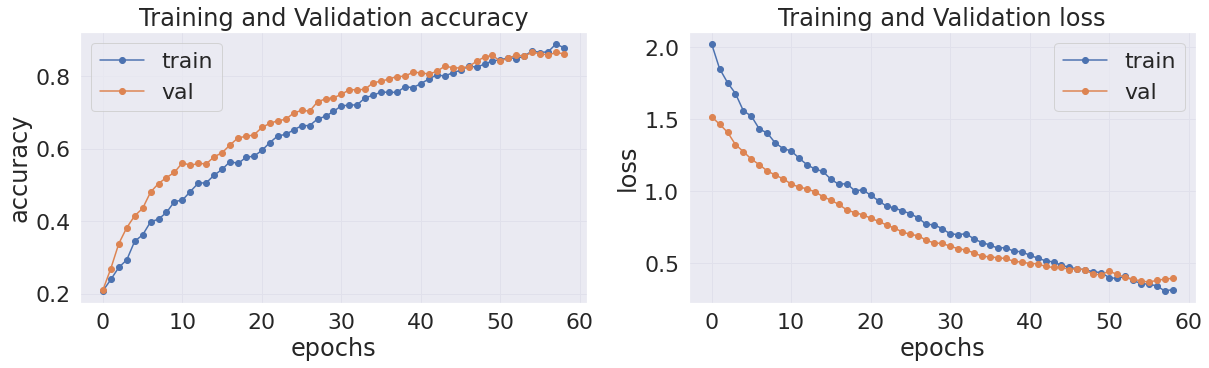

In [17]:

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
for i, met in enumerate([ 'accuracy', 'loss']):
    ax[i].plot(history.history[met] , 'o-')
    ax[i].plot(history.history['val_' + met], 'o-')
    ax[i].set_title('Training and Validation {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'],loc='best')

fig.savefig('model1_accuracy_loss',dpi=1200); 

plt.show()

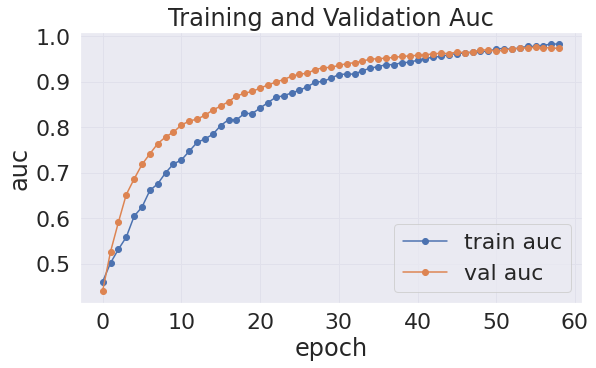

In [18]:

plt.figure(figsize=(9, 5))
ax = plt.axes()
ax.set_facecolor("#eaeaf2")
plt.plot(history.history['auc'],'o-',label="train auc")
plt.plot(history.history['val_auc'],'o-',label="val auc")
plt.title('Training and Validation Auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend()
plt.grid(color = '#e0e0eb')
plt.savefig('model1_accuracy',dpi=1200); 
plt.show()


In [19]:
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


##1st Step

In [20]:
def grad_cam_keras(image_dir):
  image = cv2.imread(image_dir)
  #image = [img for img in os.listdir(image_dir) if img.endswith(".jpg")]
  image = cv2.resize(image, (299, 299))
  # image=cv2.imread(image_dir)
  # print(image)
  # try:
  #   image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
  #   print(image.shape)
  # except:
  # break

  #   height, width , layers = image.shape
  #   size=(width,height)
  # print(size)

  image = image.astype('float32') / 255
  image = np.expand_dims(image, axis=0)

  preds = model.predict(image) 
  i = np.argmax(preds[0])
  icam = GradCAM(model, i, 'block1_conv1') 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (299, 299))

  image = cv2.imread(image_dir)
  image = cv2.resize(image, (299, 299))
  
  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].imshow(image, aspect='auto')
  ax[1].imshow(output, aspect='auto')


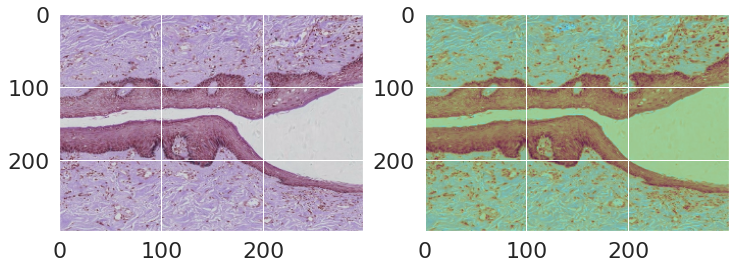

In [21]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/0/0.695.jpg')

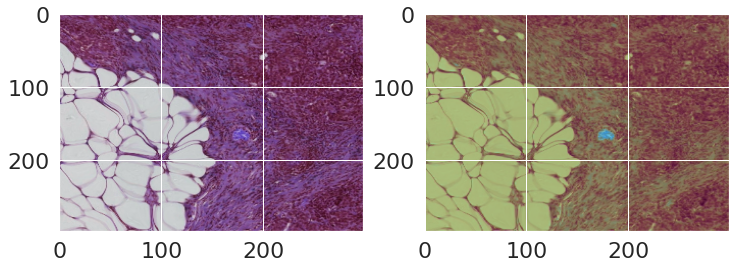

In [22]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/1/1.542.jpg')

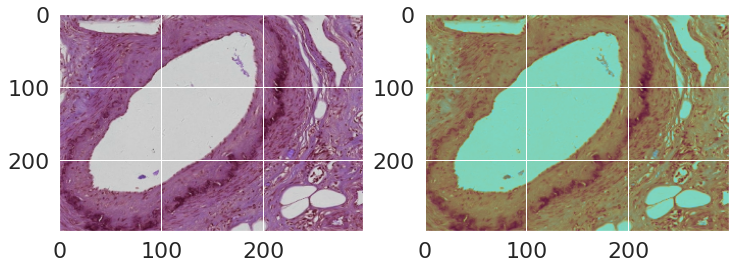

In [23]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/2/2.74.jpg')

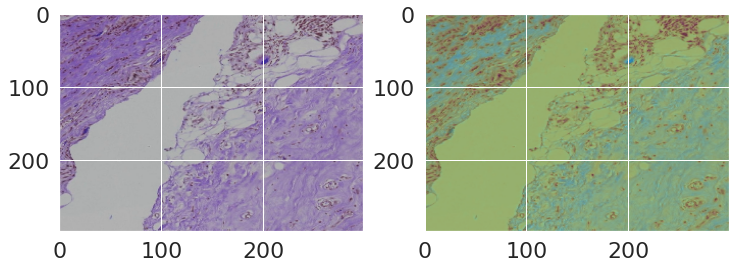

In [24]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/3/3.703.jpg')


##2nd Step

In [27]:
def grad_cam_keras(image_dir):
  image = cv2.imread(image_dir)
  #image = [img for img in os.listdir(image_dir) if img.endswith(".jpg")]
  image = cv2.resize(image, (299, 299))
  # image=cv2.imread(image_dir)
  # print(image)
  # try:
  #   image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
  #   print(image.shape)
  # except:
  # break

  #   height, width , layers = image.shape
  #   size=(width,height)
  # print(size)

  image = image.astype('float32') / 255
  image = np.expand_dims(image, axis=0)

  preds = model.predict(image) 
  i = np.argmax(preds[0])
  icam = GradCAM(model, i, 'block5_sepconv1_act') 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (299, 299))

  image = cv2.imread(image_dir)
  image = cv2.resize(image, (299, 299))
  
  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].imshow(image, aspect='auto')
  ax[1].imshow(output, aspect='auto')


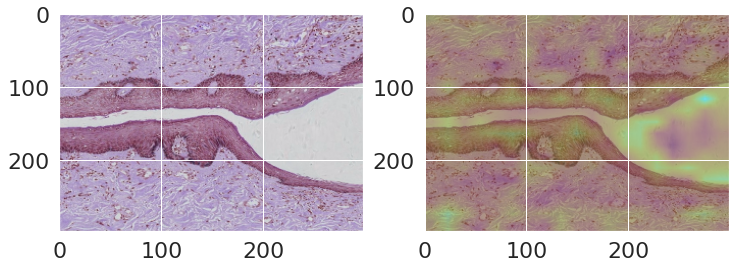

In [28]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/0/0.695.jpg')

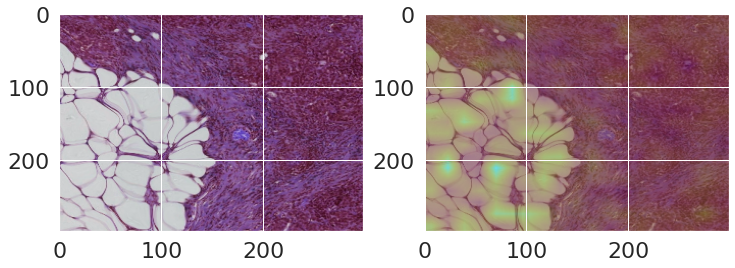

In [29]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/1/1.542.jpg')

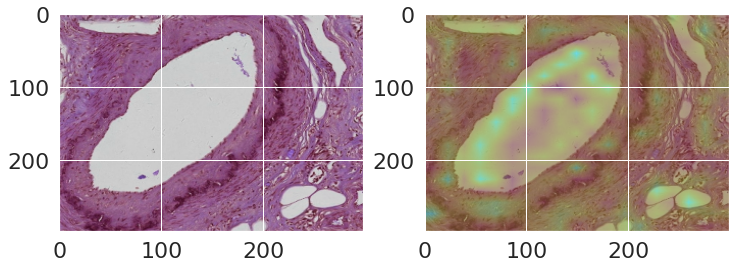

In [30]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/2/2.74.jpg')

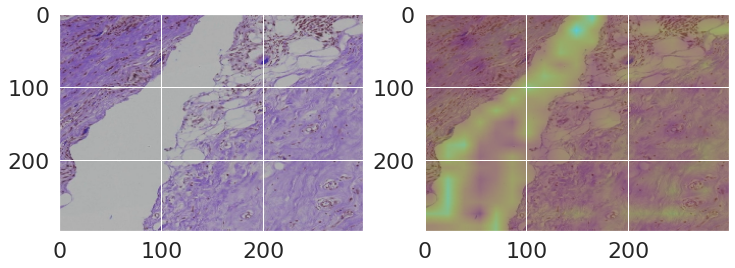

In [31]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/3/3.703.jpg')

##3rd Step

In [32]:
def grad_cam_keras(image_dir):
  image = cv2.imread(image_dir)
  #image = [img for img in os.listdir(image_dir) if img.endswith(".jpg")]
  image = cv2.resize(image, (299, 299))
  # image=cv2.imread(image_dir)
  # print(image)
  # try:
  #   image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
  #   print(image.shape)
  # except:
  # break

  #   height, width , layers = image.shape
  #   size=(width,height)
  # print(size)

  image = image.astype('float32') / 255
  image = np.expand_dims(image, axis=0)

  preds = model.predict(image) 
  i = np.argmax(preds[0])
  icam = GradCAM(model, i, 'block10_sepconv1_act') 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (299, 299))

  image = cv2.imread(image_dir)
  image = cv2.resize(image, (299, 299))
  
  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].imshow(image, aspect='auto')
  ax[1].imshow(output, aspect='auto')


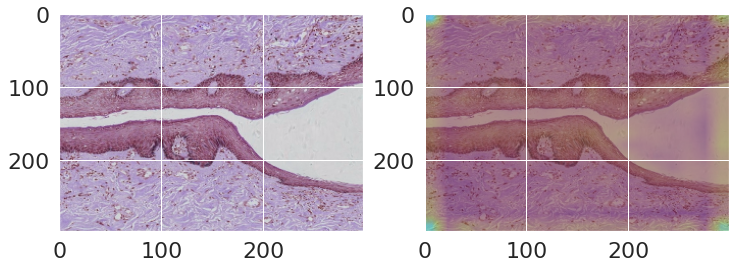

In [33]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/0/0.695.jpg')

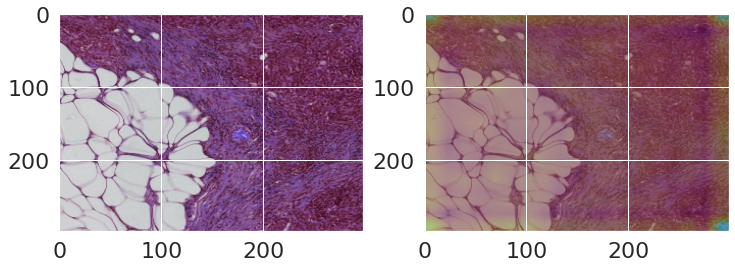

In [34]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/1/1.542.jpg')

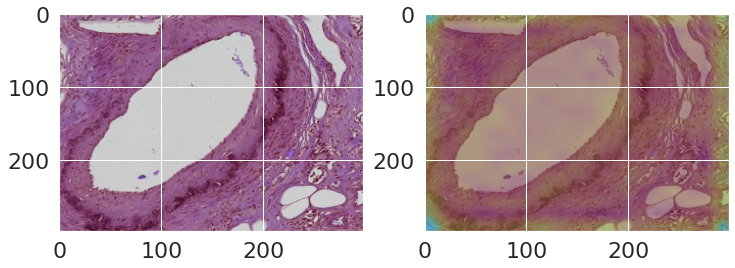

In [35]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/2/2.74.jpg')

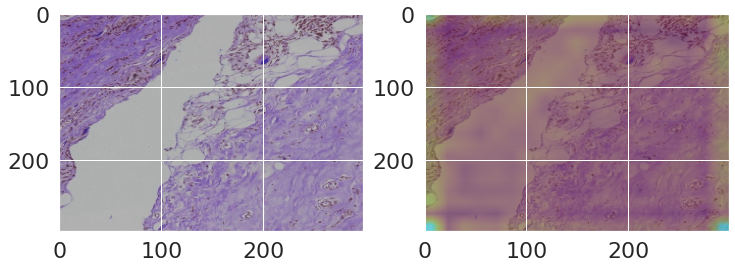

In [36]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/3/3.703.jpg')

##4rth Step

In [37]:
def grad_cam_keras(image_dir):
  image = cv2.imread(image_dir)
  #image = [img for img in os.listdir(image_dir) if img.endswith(".jpg")]
  image = cv2.resize(image, (299, 299))
  # image=cv2.imread(image_dir)
  # print(image)
  # try:
  #   image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
  #   print(image.shape)
  # except:
  # break

  #   height, width , layers = image.shape
  #   size=(width,height)
  # print(size)

  image = image.astype('float32') / 255
  image = np.expand_dims(image, axis=0)

  preds = model.predict(image) 
  i = np.argmax(preds[0])
  icam = GradCAM(model, i, 'block14_sepconv2_act') 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (299, 299))

  image = cv2.imread(image_dir)
  image = cv2.resize(image, (299, 299))
  
  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].imshow(image, aspect='auto')
  ax[1].imshow(output, aspect='auto')


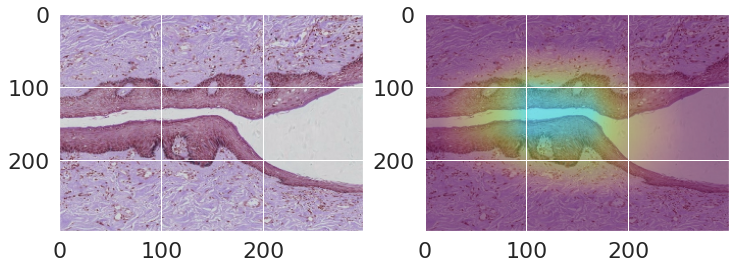

In [38]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/0/0.695.jpg')

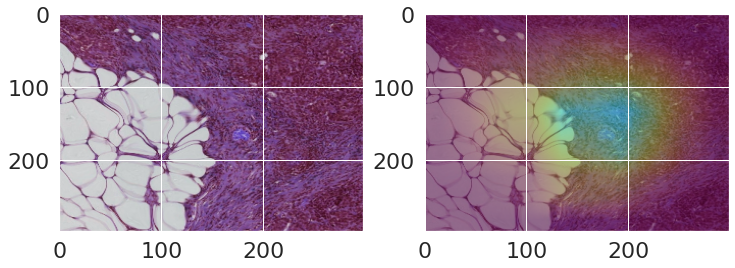

In [39]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/1/1.542.jpg')

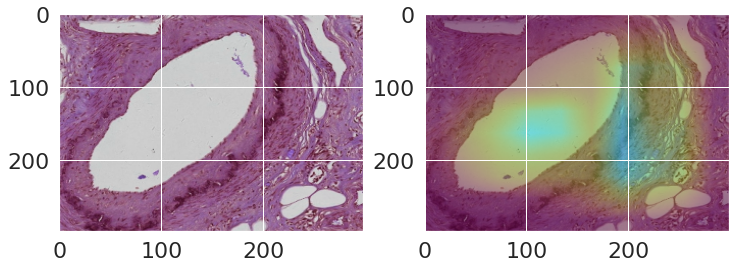

In [40]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/2/2.74.jpg')

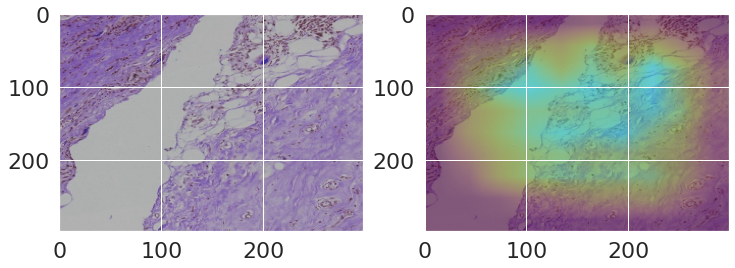

In [41]:
grad_cam_keras(image_dir = '/content/drive/MyDrive/HE/test/3/3.703.jpg')

In [42]:
model.save("/content/drive/MyDrive/IHE-HE_M-Xception.h5")